In [1]:
#Test class for data loading
from FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset

dataset_train = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[2, 3, 4, 5],
        cutoff_dist=0.3,  
        use_static_features=False, 
    )

dataset_val = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[6, 7],
        cutoff_dist=0.3,  
        use_static_features=False,  
    )

dataset_test = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[8, 9],
        cutoff_dist=0.3,  
        use_static_features=False,  
    )

# Apply to loaded datasets
dataset_test[0]

Loading systems: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Data(x=[800, 5], edge_index=[2, 9424], edge_attr=[9424, 4], y=[800, 3], pos=[800, 3], system_id=8, timestep=0)

In [2]:
from FeGdSpinGNN.utils import compute_normalization_stats, normalize_data

stats = compute_normalization_stats(dataset_train)
train_normalized = [normalize_data(data, stats) for data in dataset_train]
val_normalized = [normalize_data(data, stats) for data in dataset_val]
test_normalized = [normalize_data(data, stats) for data in dataset_test]

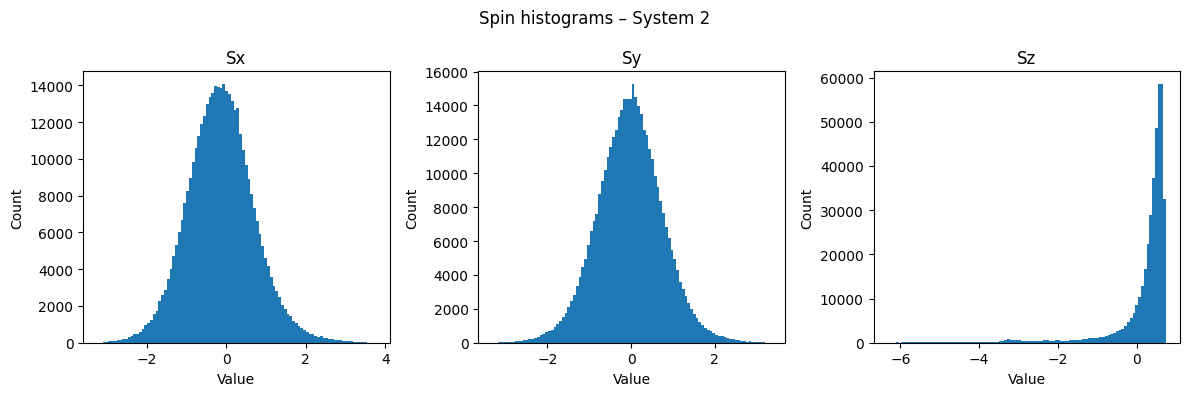

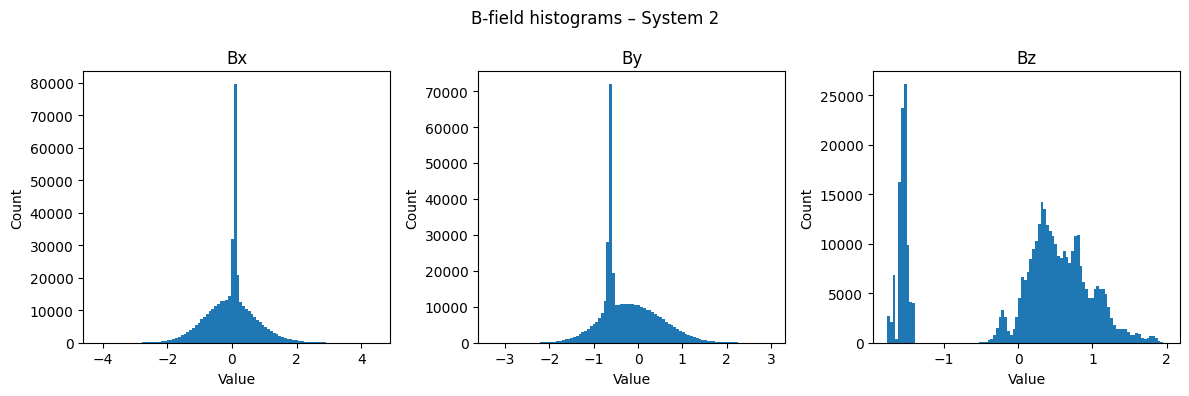

In [8]:
from FeGdSpinGNN_NonEqui.common.utils import plot_spin_B_histograms
plot_spin_B_histograms(train_normalized, systems=[2], bins=100)

In [3]:
from torch_geometric.loader import DataLoader
batch_size = 16

train_loader = DataLoader(train_normalized, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_normalized, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_normalized, batch_size=batch_size, shuffle=False)

In [4]:
import torch
import torch.optim as optim
from FeGdSpinGNN_NonEqui.models.InvariantFeGdFieldModel import InvariantFeGdBFieldModel
from FeGdSpinGNN_NonEqui.models.baseline_gnn import NaiveFeGdBFieldModel
import torch.nn as nn

# Initialize model
model = NaiveFeGdBFieldModel(
    node_in_dim=5,      
    hidden_dim=32,     
    num_layers=2,       
    dropout=0.2         
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=10,
    factor=0.5,
    min_lr=1e-6
)

In [6]:
from FeGdSpinGNN_NonEqui.FeGd_trainer import mse_loss, SimpleTrainer

trainer = SimpleTrainer(
    model=model,
    device=device,
    optimizer=optimizer,
    scheduler=scheduler,
)

In [7]:
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
)

Epoch   1 | Train 0.7950 | Val 0.7172


Epoch   2 | Train 0.5760 | Val 0.6543


Epoch   3 | Train 0.5479 | Val 0.6537


Epoch   4 | Train 0.5365 | Val 0.6586


Epoch   5 | Train 0.5273 | Val 0.6652


KeyboardInterrupt: 

In [ ]:
#TODO: Evaluate MSE if predictions are only mean or only zero


In [ ]:
# Evaluate on test set
model.load_state_dict(torch.load("best_model.pth"))
test_loss = trainer.evaluate(test_loader)
print(f"Test MSE Loss: {test_loss:.6f}")